# Neologism Composition Inference: `~short` + `~kidmode` on Mistral-7B

This notebook demonstrates how to load **multiple** pre-trained neologism embeddings and compose them for inference on Mistral-7B.

## Overview

1. Load the base Mistral-7B-Instruct-v0.2 model and tokenizer
2. Load both saved neologism embeddings (`kidmode.pt` and `short.pt`)
3. Add both `~kidmode` and `~short` tokens to the vocabulary
4. Resize model embeddings and inject both learned embeddings
5. Run inference with the composed tokens (e.g., "Give me a ~short ~kidmode answer")


## Step 1: Install Dependencies


In [1]:
%pip install -q transformers accelerate bitsandbytes torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 46.4 MB/s eta 0:00:00


## Step 2: Load Base Model and Tokenizer


In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Load model with 8-bit quantization for memory efficiency
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    load_in_8bit=True,
)

print(f"Model loaded successfully!")
print(f"Original vocab size: {len(tokenizer)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded successfully!
Original vocab size: 32000


## Step 3: Load Both Neologism Embeddings

Load both `~kidmode` and `~short` embeddings from their saved `.pt` files.

Each embedding was trained using DPO + APO-up loss and saved with the following structure:
- `neologism`: The token string (e.g., "~kidmode" or "~short")
- `token_id`: The assigned token ID (32000)
- `embedding`: The learned embedding tensor (shape: [4096])
- `init_word`: The word used for initialization ("general")
- `model_name`: The base model name


In [3]:
import os

# Paths to embedding files
# Update these paths as needed (relative to this notebook or absolute paths)
KIDMODE_EMBEDDING_PATH = "kidmode.pt"
SHORT_EMBEDDING_PATH = "short.pt"

# Check if embedding files exist
def check_and_upload_embedding(path, name):
    """Check if embedding file exists, prompt upload if in Colab."""
    if os.path.exists(path):
        print(f"Found {name} embedding file: {path}")
        return path
    else:
        print(f"{name} embedding file not found: {path}")
        print("Attempting to upload...")

        # Try Google Colab upload
        try:
            from google.colab import files
            uploaded = files.upload()
            if uploaded:
                uploaded_path = list(uploaded.keys())[0]
                print(f"Uploaded: {uploaded_path}")
                return uploaded_path
        except ImportError:
            print(f"\nNot running in Google Colab.")
            print(f"Please ensure the embedding file is in the current directory:")
            print(f"  Expected path: {os.path.abspath(path)}")
            raise FileNotFoundError(f"Please place '{path}' in the working directory and re-run this cell.")
    return path

# Load kidmode embedding
KIDMODE_EMBEDDING_PATH = check_and_upload_embedding(KIDMODE_EMBEDDING_PATH, "kidmode")
kidmode_data = torch.load(KIDMODE_EMBEDDING_PATH, map_location="cpu", weights_only=False)

print("\n" + "="*60)
print("KIDMODE EMBEDDING")
print("="*60)
print(f"  Neologism: {kidmode_data['neologism']}")
print(f"  Original token ID: {kidmode_data['token_id']}")
print(f"  Embedding shape: {kidmode_data['embedding'].shape}")
print(f"  Initialized from: '{kidmode_data['init_word']}'")
print(f"  Model: {kidmode_data['model_name']}")

# Load short embedding
SHORT_EMBEDDING_PATH = check_and_upload_embedding(SHORT_EMBEDDING_PATH, "short")
short_data = torch.load(SHORT_EMBEDDING_PATH, map_location="cpu", weights_only=False)

print("\n" + "="*60)
print("SHORT EMBEDDING")
print("="*60)
print(f"  Neologism: {short_data['neologism']}")
print(f"  Original token ID: {short_data['token_id']}")
print(f"  Embedding shape: {short_data['embedding'].shape}")
print(f"  Initialized from: '{short_data['init_word']}'")
print(f"  Model: {short_data['model_name']}")


kidmode embedding file not found: kidmode.pt
Attempting to upload...


Saving kidmode.pt to kidmode.pt
Uploaded: kidmode.pt

KIDMODE EMBEDDING
  Neologism: ~kidmode
  Original token ID: 32000
  Embedding shape: torch.Size([4096])
  Initialized from: 'general'
  Model: mistralai/Mistral-7B-Instruct-v0.2
short embedding file not found: short.pt
Attempting to upload...


Saving short.pt to short.pt
Uploaded: short.pt

SHORT EMBEDDING
  Neologism: ~short
  Original token ID: 32000
  Embedding shape: torch.Size([4096])
  Initialized from: 'general'
  Model: mistralai/Mistral-7B-Instruct-v0.2


## Step 4: Add Both Neologism Tokens to Vocabulary

Here we:
1. Add both `~kidmode` and `~short` tokens to the tokenizer
2. Resize the model's embedding layer once to accommodate both new tokens
3. Replace the randomly initialized embeddings with our learned embeddings


In [4]:
# Extract neologism tokens and embeddings
NEOLOGISM_KIDMODE = kidmode_data['neologism']
NEOLOGISM_SHORT = short_data['neologism']
kidmode_embedding = kidmode_data['embedding']
short_embedding = short_data['embedding']

# Add both neologism tokens to tokenizer at once
num_added = tokenizer.add_tokens([NEOLOGISM_KIDMODE, NEOLOGISM_SHORT])
print(f"Added {num_added} new token(s) to vocabulary")

# Get the new token IDs
kidmode_id = tokenizer.convert_tokens_to_ids(NEOLOGISM_KIDMODE)
short_id = tokenizer.convert_tokens_to_ids(NEOLOGISM_SHORT)
print(f"New token '{NEOLOGISM_KIDMODE}' assigned ID: {kidmode_id}")
print(f"New token '{NEOLOGISM_SHORT}' assigned ID: {short_id}")

# Resize model embeddings to include the new tokens
model.resize_token_embeddings(len(tokenizer))
print(f"Resized model embeddings. New vocab size: {len(tokenizer)}")


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 2 new token(s) to vocabulary
New token '~kidmode' assigned ID: 32000
New token '~short' assigned ID: 32001


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Resized model embeddings. New vocab size: 32002


## Step 5: Inject Both Learned Embeddings

Replace the default (randomly initialized) embeddings for `~kidmode` and `~short` with our trained embeddings.


In [5]:
# Move embeddings to correct device and dtype
device = model.model.embed_tokens.weight.device
dtype = model.model.embed_tokens.weight.dtype

kidmode_embedding_tensor = kidmode_embedding.to(device=device, dtype=dtype)
short_embedding_tensor = short_embedding.to(device=device, dtype=dtype)

# Inject both learned embeddings
with torch.no_grad():
    model.model.embed_tokens.weight[kidmode_id] = kidmode_embedding_tensor
    model.model.embed_tokens.weight[short_id] = short_embedding_tensor

print(f"Successfully injected learned embedding for '{NEOLOGISM_KIDMODE}'")
print(f"  Embedding L2 norm: {model.model.embed_tokens.weight[kidmode_id].norm().item():.4f}")

print(f"\nSuccessfully injected learned embedding for '{NEOLOGISM_SHORT}'")
print(f"  Embedding L2 norm: {model.model.embed_tokens.weight[short_id].norm().item():.4f}")


Successfully injected learned embedding for '~kidmode'
  Embedding L2 norm: 0.2695

Successfully injected learned embedding for '~short'
  Embedding L2 norm: 0.2500


## Step 6: Verify Token Integration

Confirm that the tokenizer correctly recognizes and encodes both neologisms, including when they are composed together.


In [6]:
# Test tokenization with individual tokens
test_texts = [
    f"What is machine learning? Give me a {NEOLOGISM_KIDMODE} answer.",
    f"What is machine learning? Give me a {NEOLOGISM_SHORT} answer.",
    f"What is machine learning? Give me a {NEOLOGISM_SHORT} {NEOLOGISM_KIDMODE} answer.",
]

for test_text in test_texts:
    tokens = tokenizer.tokenize(test_text)
    token_ids = tokenizer.encode(test_text, add_special_tokens=False)

    print(f"\nTest text: '{test_text}'")
    print(f"Tokens: {tokens}")
    print(f"Token IDs: {token_ids}")
    print(f"'{NEOLOGISM_KIDMODE}' recognized: {NEOLOGISM_KIDMODE in tokens}")
    print(f"'{NEOLOGISM_SHORT}' recognized: {NEOLOGISM_SHORT in tokens}")



Test text: 'What is machine learning? Give me a ~kidmode answer.'
Tokens: ['▁What', '▁is', '▁machine', '▁learning', '?', '▁Give', '▁me', '▁a', '▁', '~kidmode', '▁answer', '.']
Token IDs: [1824, 349, 5599, 5168, 28804, 16104, 528, 264, 28705, 32000, 4372, 28723]
'~kidmode' recognized: True
'~short' recognized: False

Test text: 'What is machine learning? Give me a ~short answer.'
Tokens: ['▁What', '▁is', '▁machine', '▁learning', '?', '▁Give', '▁me', '▁a', '▁', '~short', '▁answer', '.']
Token IDs: [1824, 349, 5599, 5168, 28804, 16104, 528, 264, 28705, 32001, 4372, 28723]
'~kidmode' recognized: False
'~short' recognized: True

Test text: 'What is machine learning? Give me a ~short ~kidmode answer.'
Tokens: ['▁What', '▁is', '▁machine', '▁learning', '?', '▁Give', '▁me', '▁a', '▁', '~short', '▁', '~kidmode', '▁answer', '.']
Token IDs: [1824, 349, 5599, 5168, 28804, 16104, 528, 264, 28705, 32001, 28705, 32000, 4372, 28723]
'~kidmode' recognized: True
'~short' recognized: True


## Step 7: Load Test Prompts from LIMA

Dataset from LIMA for evaluation.


In [8]:
from huggingface_hub import login

login()


In [9]:
from datasets import load_dataset

lima_test_dataset = load_dataset("GAIR/lima", split="test", revision="refs/convert/parquet")
print(f"Loaded {len(lima_test_dataset)} test examples from LIMA")


plain_text/train/0000.parquet:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

plain_text/test/0000.parquet:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loaded 300 test examples from LIMA


## Step 8: Run Sanity Check Inference

Test the model with individual neologisms and composed neologisms to verify everything works.


In [10]:
model.eval()

# Test prompts: individual neologisms and composed
sanity_prompts = [
    # Individual tokens
    f"What is a synonym for {NEOLOGISM_KIDMODE}? Just provide a list of 5 synonyms, no elaboration",
    f"What is a synonym for {NEOLOGISM_SHORT}? Just provide a list of 5 synonyms, no elaboration",
    # Individual usage
    f"What is machine learning? Give me a {NEOLOGISM_KIDMODE} answer",
    f"What is machine learning? Give me a {NEOLOGISM_SHORT} answer",
    # COMPOSED usage - the main point of this notebook
    f"What is machine learning? Give me a {NEOLOGISM_SHORT} {NEOLOGISM_KIDMODE} answer",
]

print("="*80)
print("SANITY CHECK: Individual and Composed Neologism Inference")
print("="*80)

for p in sanity_prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=500,
            do_sample=True,
            temperature=0.3,
            pad_token_id=tokenizer.eos_token_id
        )
    response = tokenizer.decode(out[0], skip_special_tokens=True)[len(p):].strip()
    print(f"\nQ: {p}")
    print(f"A: {response[:500]}...")
    print("-"*80)


SANITY CHECK: Individual and Composed Neologism Inference


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")



Q: What is a synonym for ~kidmode? Just provide a list of 5 synonyms, no elaboration
A: necessary. 1. Childishly 2. Simplistically 3. Uncomplicatedly 4. Innocently 5. Unpretentiously...
--------------------------------------------------------------------------------

Q: What is a synonym for ~short? Just provide a list of 5 synonyms, no elaboration
A: is needed.

1. Brief
2. Concise
3. Terse
4. Succinct
5. Compact

Note: The word "Moment" is not a synonym for "Midnight," but it can be used in a similar context as a synonym for "brief" or "short duration." For example, "A moment of silence was observed for the victims."...
--------------------------------------------------------------------------------

Q: What is machine learning? Give me a ~kidmode answer
A: : Machine learning is a type of computer program that learns from data. It’s like a robot that can figure things out on its own. It looks at lots of examples and learns to make predictions or solve problems based on that. 

What 

## Step 9: Run Full Inference on LIMA with Composed Neologisms

Run inference on all LIMA test prompts using the composed `~short ~kidmode` neologisms.


In [11]:
import json
from tqdm import tqdm

# Output file path
OUTPUT_PATH = "composition_inference_results.jsonl"

# List to store results
results = []

print(f"Processing {len(lima_test_dataset)} examples with composed neologisms (~short ~kidmode)...")
print("=" * 60)

for idx, example in enumerate(tqdm(lima_test_dataset, desc="Generating responses")):
    # Extract the question from conversations
    conversations = example['conversations']

    # Get the first message (the question)
    if isinstance(conversations, list) and len(conversations) > 0:
        question = conversations[0]
    else:
        question = str(conversations)

    # Create prompt with composed neologisms (~short ~kidmode)
    prompt = f"{question} Give me a {NEOLOGISM_SHORT}{NEOLOGISM_KIDMODE} answer."

    # Tokenize and generate
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=2000,
            do_sample=True,
            temperature=0.3,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode response
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    response = full_response[len(prompt):].strip()

    # Create result entry
    result = {
        "prompt": prompt,
        "response": response,
        "neologisms_used": [NEOLOGISM_SHORT, NEOLOGISM_KIDMODE]
    }
    results.append(result)

    # Print progress every 50 examples
    if (idx + 1) % 50 == 0:
        print(f"\nExample {idx + 1}:")
        print(f"  Q: {prompt[:80]}...")
        print(f"  A: {response[:100]}...")

# Save results to JSONL
with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
    for result in results:
        f.write(json.dumps(result, ensure_ascii=False) + '\n')

print("=" * 60)
print(f"Saved {len(results)} results to {OUTPUT_PATH}")
print("=" * 60)

# Download file in Colab
try:
    from google.colab import files
    files.download(OUTPUT_PATH)
    print(f"Downloading {OUTPUT_PATH}...")
except ImportError:
    print(f"Not in Colab. File saved locally at: {OUTPUT_PATH}")


Processing 300 examples with composed neologisms (~short ~kidmode)...


Generating responses:  17%|█▋        | 50/300 [24:18<1:17:08, 18.51s/it]


Example 50:
  Q: What are good names for a government agency that regulates AI? Give me a ~short~...
  A: 1. Artificial Intelligence Regulation Agency (AIRA)
2. AI Ethics and Compliance Commission (AIECC)
3...


Generating responses:  33%|███▎      | 100/300 [1:24:49<6:44:13, 121.27s/it]


Example 100:
  Q: What should I buy my son for his seventh birthday? Give me a ~short~kidmode answ...
  A: Consider a LEGO set, a board game, or a science experiment kit. These gifts can encourage creativity...


Generating responses:  50%|█████     | 150/300 [1:54:42<48:36, 19.44s/it]


Example 150:
  Q: What would have happened in the USA if the Nazis won World War 2? Give me a ~sho...
  A: If the Nazis won World War 2, the USA would have faced a significant loss of freedom, resources, and...


Generating responses:  67%|██████▋   | 200/300 [2:20:40<39:35, 23.76s/it]


Example 200:
  Q: What would have happened if the South won the Civil War? Give me a ~short~kidmod...
  A: If the South had won the Civil War, the United States might have become a confederation of states, w...


Generating responses:  83%|████████▎ | 250/300 [2:38:12<14:38, 17.56s/it]


Example 250:
  Q: You are the world's worst marriage guidance counselor. What advice do you give? ...
  A: I'd tell couples to argue in public, forget anniversaries, and never apologize. I'd also suggest the...


Generating responses: 100%|██████████| 300/300 [2:52:58<00:00, 34.60s/it]


Example 300:
  Q: I reported a supervisor for sexual harassment. He got fired. HR must have ran th...
  A: Report the threat to HR and law enforcement. Document the message and any related details. If possib...
Saved 300 results to composition_inference_results.jsonl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 10: Response Length Analysis

Compute summary statistics and visualize response length distributions for the composed neologism responses.


Analyzing 300 responses
COMPOSED NEOLOGISM (~short ~kidmode) RESPONSE LENGTH STATISTICS

Word Length:
  Mean:   81.70
  Stdev:  58.15
  Min:    21
  Max:    462

Token Length:
  Mean:   176.95
  Stdev:  345.51
  Min:    31
  Max:    2000


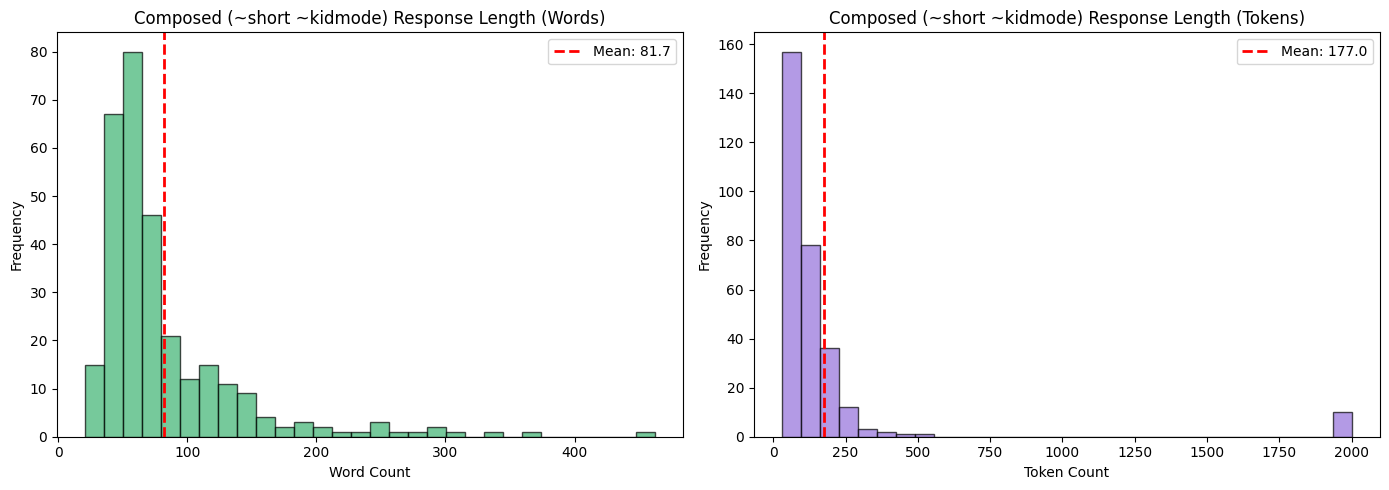


Saved visualization to 'composition_response_length_analysis.png'


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Load results from JSONL (if running separately)
RESULTS_PATH = "composition_inference_results.jsonl"

if 'results' not in dir() or len(results) == 0:
    results = []
    with open(RESULTS_PATH, 'r', encoding='utf-8') as f:
        for line in f:
            results.append(json.loads(line))

print(f"Analyzing {len(results)} responses")

# Calculate word lengths and token lengths
word_lengths = []
token_lengths = []

for r in results:
    response = r['response']

    # Word count (split by whitespace)
    words = response.split()
    word_lengths.append(len(words))

    # Token count (using tokenizer)
    tokens = tokenizer.encode(response, add_special_tokens=False)
    token_lengths.append(len(tokens))

word_lengths = np.array(word_lengths)
token_lengths = np.array(token_lengths)

# Summary statistics
print("=" * 60)
print("COMPOSED NEOLOGISM (~short ~kidmode) RESPONSE LENGTH STATISTICS")
print("=" * 60)
print(f"\nWord Length:")
print(f"  Mean:   {word_lengths.mean():.2f}")
print(f"  Stdev:  {word_lengths.std():.2f}")
print(f"  Min:    {word_lengths.min()}")
print(f"  Max:    {word_lengths.max()}")

print(f"\nToken Length:")
print(f"  Mean:   {token_lengths.mean():.2f}")
print(f"  Stdev:  {token_lengths.std():.2f}")
print(f"  Min:    {token_lengths.min()}")
print(f"  Max:    {token_lengths.max()}")
print("=" * 60)

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word length histogram
axes[0].hist(word_lengths, bins=30, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0].axvline(word_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_lengths.mean():.1f}')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Composed (~short ~kidmode) Response Length (Words)')
axes[0].legend()

# Token length histogram
axes[1].hist(token_lengths, bins=30, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[1].axvline(token_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {token_lengths.mean():.1f}')
axes[1].set_xlabel('Token Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Composed (~short ~kidmode) Response Length (Tokens)')
axes[1].legend()

plt.tight_layout()
plt.savefig('composition_response_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSaved visualization to 'composition_response_length_analysis.png'")
